In [1]:
import tensorflow as tf
from keras.models import model_from_json
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import imageio
from matplotlib import pyplot as plt
import warnings
import cv2
import pandas as pd
from mtcnn.mtcnn import MTCNN
import keras.backend as K
from keras.layers import Input,ConvLSTM2D,GRU, BatchNormalization, Activation, Bidirectional, Dense, Reshape, Conv2D, MaxPooling3D, UpSampling2D,Lambda, TimeDistributed,Flatten, LSTM
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
warnings.filterwarnings("ignore")
from keras.callbacks import TensorBoard, CSVLogger, ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [3]:
def _ctc_lambda_func(args):
    labels, y_pred, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return K.tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


input_layer = Input(shape=(30, 100, 50,3),name='input')
labels = Input(shape=(12,),name='labels')
input_length = Input(shape=(1,),name='input_length')
label_length = Input(shape=(1,),name='label_length')

conv_lstm_1 = ConvLSTM2D(activation='relu',filters=32,return_sequences=True,kernel_size=(3,3),padding='same',recurrent_activation='relu')(input_layer)
conv_lstm_1 = BatchNormalization()(conv_lstm_1)
conv_lstm_1 = Activation(activation='relu')(conv_lstm_1)
max_pool_1 = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_1)

conv_lstm_2 = ConvLSTM2D(activation='relu',filters=32,return_sequences=True,kernel_size=(3,3),padding='same',recurrent_activation='relu')(max_pool_1)
conv_lstm_2 = BatchNormalization()(conv_lstm_2)
conv_lstm_2 = Activation(activation='relu')(conv_lstm_2)
max_pool_2 = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_2)

conv_lstm_3 = ConvLSTM2D(activation='relu',filters=64,return_sequences=True,kernel_size=(3,3),padding='same',recurrent_activation='relu')(max_pool_2)
conv_lstm_3 = BatchNormalization()(conv_lstm_3)
conv_lstm_3 = Activation(activation='relu')(conv_lstm_3)
max_pool_3 = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_3)

conv_lstm_4 = ConvLSTM2D(activation='relu',filters=96,return_sequences=True,kernel_size=(3,3),padding='same',recurrent_activation='relu')(max_pool_3)
conv_lstm_4 = BatchNormalization()(conv_lstm_4)
conv_lstm_4 = Activation(activation='relu')(conv_lstm_4)
max_pool_4 = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_4)

flat = TimeDistributed(Flatten())(max_pool_4)
bgru = LSTM(512, return_sequences=True)(flat)
bgru = LSTM(512, return_sequences=True)(bgru)

ctc_class_dense = Dense(28,name='ctc_class_dense')(bgru)
_y_pred = Activation(activation='softmax', name='ctc_softmax')(ctc_class_dense)
gru = LSTM(512, return_sequences=False)(bgru)
# dense = Dense(128)(lstm)
cls_hidden_dense=Dense(1024,name='cls_hidden_dense')(gru)

classification_output=Dense(21,activation='softmax',name='classification')(cls_hidden_dense)

# with open('LipReading_model.json') as f:
#     loadedmodel = f.read()
# lm = model_from_json(loadedmodel)
# # ctc
# _labels = lm.get_layer('the_labels').output
# _input_length = lm.get_layer('input_length').output
# _label_length = lm.get_layer('label_length').output


ctc_loss = Lambda(_ctc_lambda_func, output_shape=(1,), name='ctc')([labels,_y_pred,input_length,label_length])
model = Model(inputs=[input_layer,labels,input_length,label_length], outputs=[classification_output,ctc_loss])
# model = Model(input_layer,[classification_output,_y_pred])


In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 30, 100, 50,  0                                            
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 30, 100, 50,  40448       input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 100, 50,  128         conv_lst_m2d_1[0][0]             
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 100, 50,  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

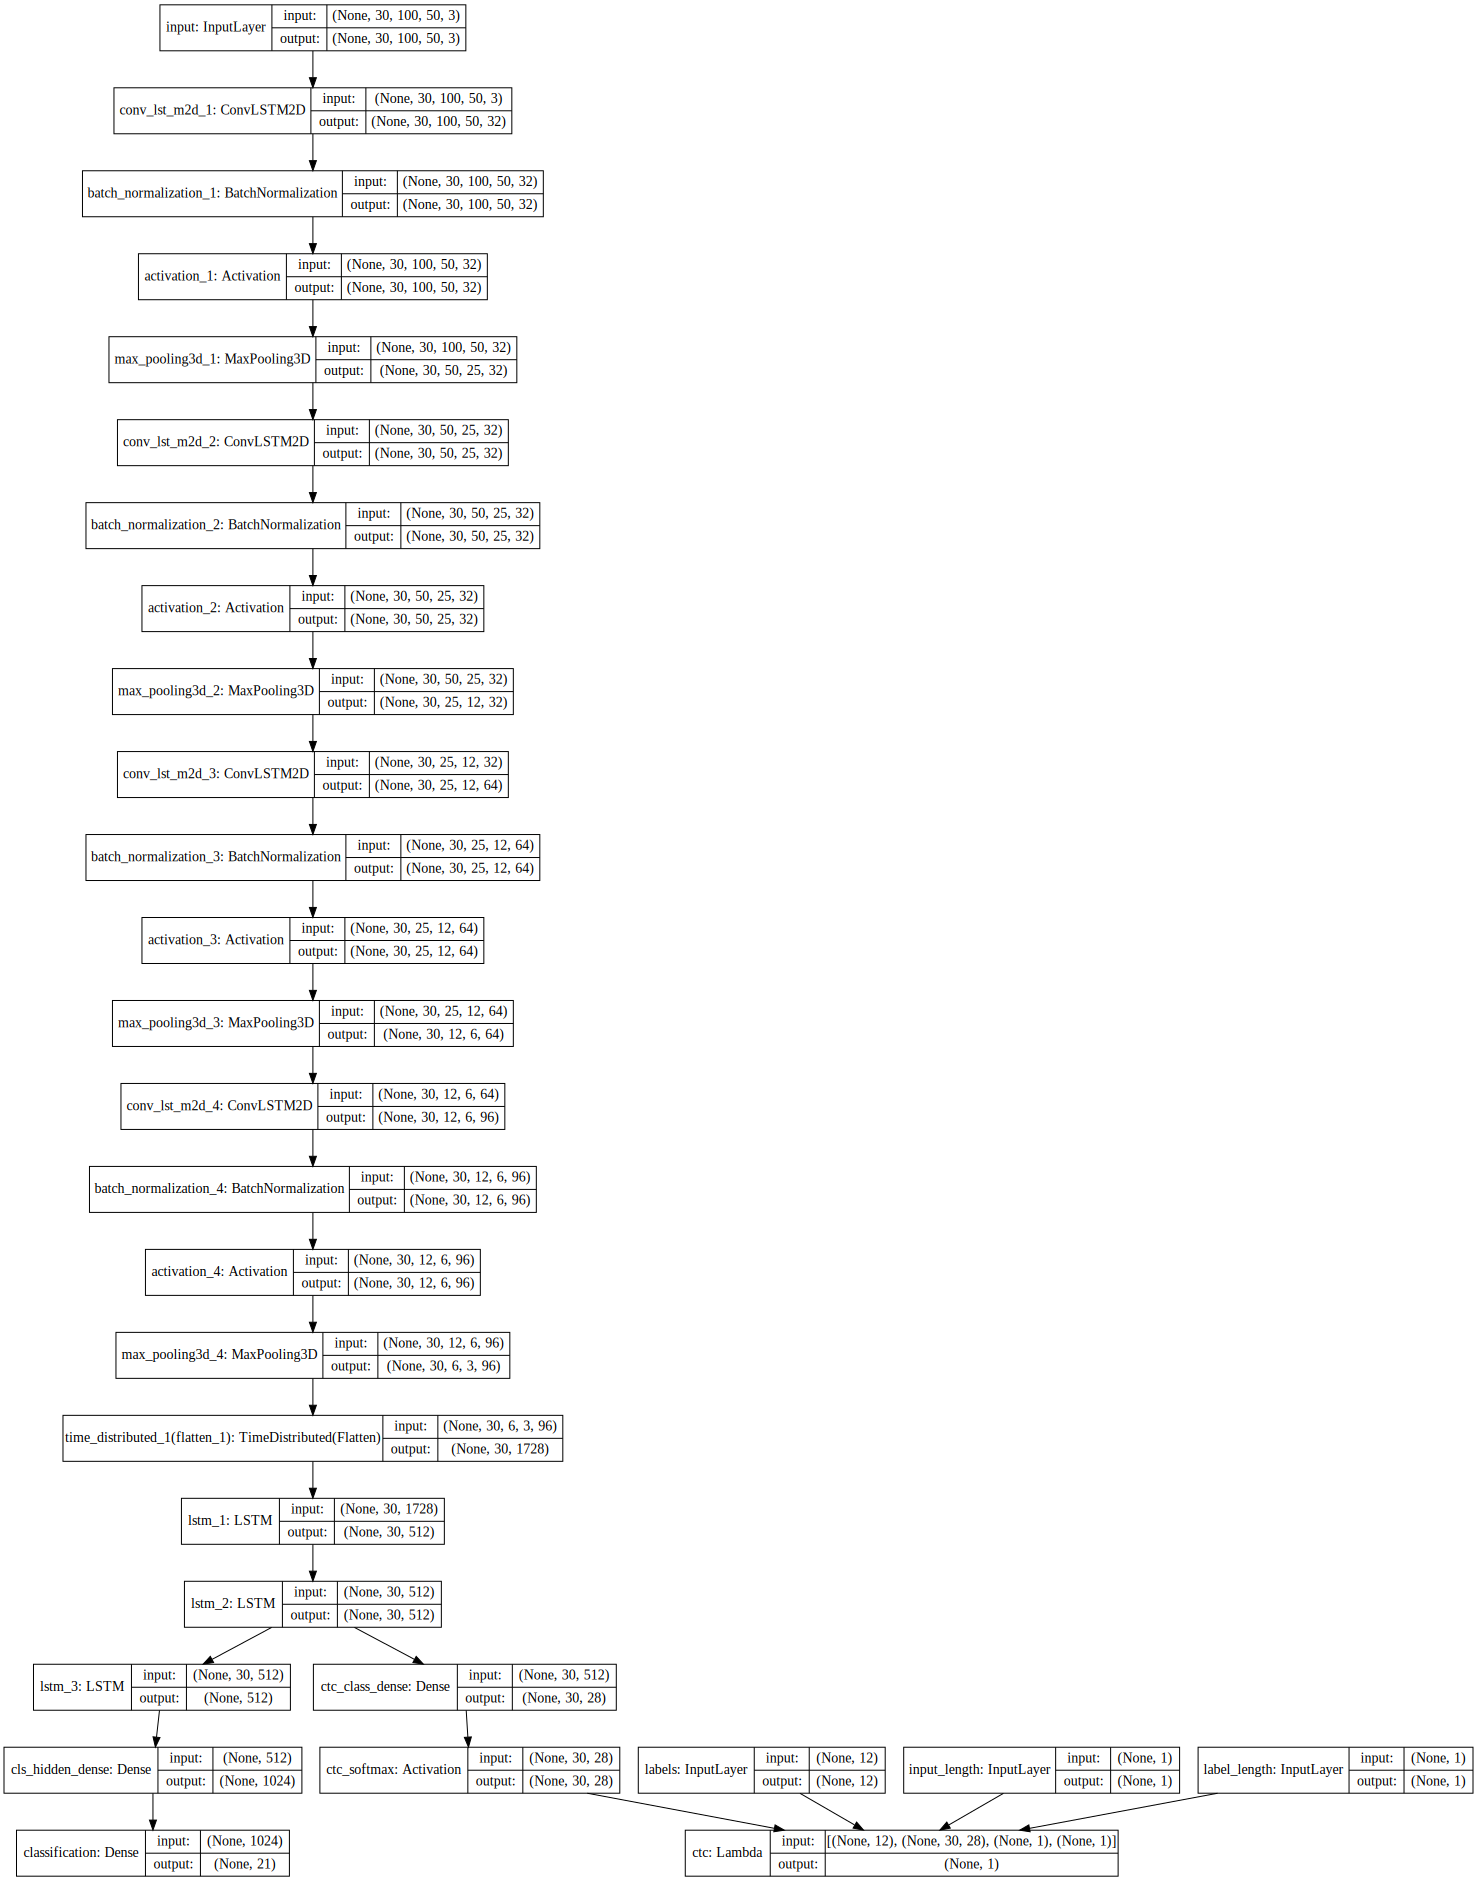

In [5]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [6]:

frames_count = 30
# words_folder = 'training/unseen_speakers/TARGET/datasets/lipread_mp4'
words = pd.read_csv('words_v2.csv')['words']
max_len = np.max([len(word) for word in words])

def datagen(data_partition = 'train', batch_size = 16):
    while True:
        counter = 0
        
        X_data = []#np.zeros((batch_size,))
        Y_data = []
        input_length = []
        label_length = []
        source_str = []
        word_id = []
        while counter<batch_size:
#             print(counter)
            word_idx = np.random.randint(len(words))
#             print('data part:', data_partition, ', word index', word_idx)
            
            train_folder = 'training/unseen_speakers/lrw_cropped/{0}/{1}/'.format(words[word_idx],data_partition)
        #         print(train_folder)
            files = os.listdir(train_folder)
        #         print(files)
            paths = list(set([x.split('.')[0] for x in files]))
        
            idx = np.random.randint(len(paths))
            path = os.path.join(train_folder,paths[idx])
#             print(path)
            frames = []
            for img_name in sorted(os.listdir(path)):
                img = cv2.imread(os.path.join(path,img_name))
                frames.append(img)
            frames = np.array(frames)
#             print(frames.shape, path)
            if len(frames.shape)==4:
#                 frames = np.rollaxis(frames,2, start=1)
    #             print(path)
    #             print(frames.shape)
    #             print('---------')
                if 'numpy.ndarray' in str(type(frames)) \
                        and len(np.shape(frames))==4 \
                        and np.shape(frames)[1] == 100 \
                        and np.shape(frames)[2] == 50:
#                     print(frames.shape, path)
                    if len(frames)<30:
                        diff = 30-len(frames)
            #             print(fr[-1].shape)
                        for i in range(diff):
                            frames = np.insert(arr = frames,values = frames[-1], obj=[-1], axis = 0)
                    X_data.append(frames)
                    ####
                    Y_data.append([ord(c) - 65 for c in words[word_idx]]+[-1]*(max_len-len(words[word_idx])))
                    input_length.append(frames_count)
                    label_length.append(len(words[word_idx]))
                    source_str.append(words[word_idx])
                    word_id.append(word_idx)
                    counter+=1
#                     print(counter)
                else:
                    continue
            else:
                print('error:', frames.shape, path)
                continue

        X_data = np.array(X_data).astype(np.float32) / 255 
        Y_data = np.array(Y_data)
        input_length = np.array(input_length)
        label_length = np.array(label_length)
        source_str = np.array(source_str)
        
        inputs = {'input': X_data,
                  'labels': Y_data,
                  'input_length': input_length,
                  'label_length': label_length,
                  'source_str': source_str  # used for visualization only
                  }
        ctc_outpts = np.zeros([batch_size])
        classes = to_categorical(y=word_id,num_classes=len(words))   
        
#         print('the_input:', inputs['the_input'].shape)
#         print('the_labels:', inputs['the_labels'].shape)
#         print('input_length:', inputs['input_length'].shape)
#         print('label_length:', inputs['label_length'].shape)
#         print('source_str:', inputs['source_str'].shape)
#         print('batch_frames_shape',X_data.shape, data_partition)

        yield inputs, [classes,ctc_outpts]

In [7]:
g_tr=datagen(data_partition='train',batch_size=16)
g_val=datagen(data_partition='val',batch_size=16)

In [8]:
for i in range(5):
    x,y=next(g_val)
#     display(x['input'].shape,np.argmax(y[0],axis=-1),x['labels'],x['input_length'],x['label_length'],x['source_str'])
# #     np.argmax(y[0],axis=1)
#     print('---------------')


In [9]:
words

0       ABSOLUTELY
1        AFTERNOON
2        AGREEMENT
3          BETWEEN
4       CONFERENCE
5     CONSERVATIVE
6        EMERGENCY
7        EVERYBODY
8         EXPECTED
9        FINANCIAL
10      GOVERNMENT
11     IMMIGRATION
12     INDEPENDENT
13      OPPOSITION
14      PARLIAMENT
15      REFERENDUM
16         SEVERAL
17     SIGNIFICANT
18    TEMPERATURES
19      THEMSELVES
20     WESTMINSTER
Name: words, dtype: object

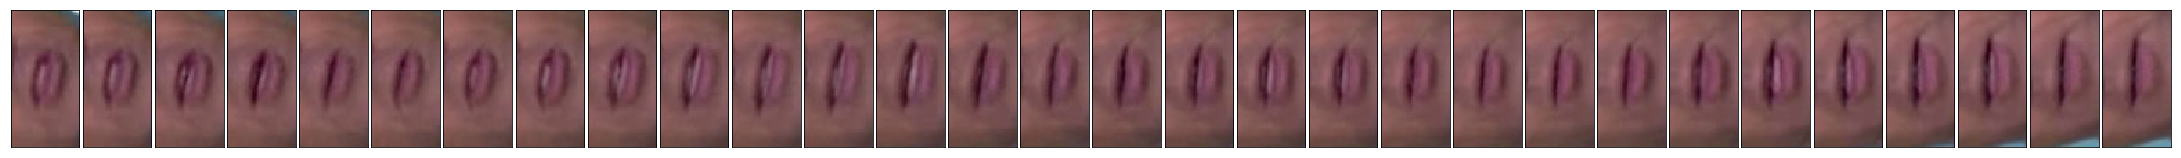

In [10]:
X = x['input'][0]
print()
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    ax.imshow(X[i])

In [11]:
# tensorboard = TensorBoard(log_dir=os.path.join(LOG_DIR, 'tune-crop-'+run_name))
# csv_logger  = CSVLogger(os.path.join(LOG_DIR, "{}-{}.csv".format('training',run_name)), separator=',', append=True)
checkpoint  = ModelCheckpoint(save_best_only=True,
                              filepath='training/unseen_speakers/results/weights-convlstm-lfw-crop-ctc-cls-v5.hdf5'
                              , monitor='val_loss'
                              , verbose=1
                              , mode='min'
                              , period=1)
# es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')   

In [12]:
# def test_loss(y_true, y_pred): 
#     return y_pred 

In [13]:
from keras.optimizers import Adadelta,Adam, SGD
# adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=1e-08)
EPOCHS = 50000
INIT_LR = 0.005
# opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
opt = Adam(lr=INIT_LR, decay=1e-6, beta_1=0.9, beta_2=0.999)
# opt = Adadelta(lr=INIT_LR, decay=1e-04)

losses = {
    'ctc':lambda y_true,y_pred:y_pred,
    'classification':'categorical_crossentropy'
}
model.compile(loss=losses, optimizer=opt, metrics=['accuracy'])


In [ ]:

# model.load_weights('training/unseen_speakers/results/weights-convlstm-lfw-crop-ctc-cls-v5.hdf5')
hist = model.fit_generator(g_tr
                    , steps_per_epoch=1
                    , epochs=EPOCHS
                    #steps_per_epoch=lip_gen.default_training_steps, epochs=stop_epoch,
                    , validation_data=g_val
                    , validation_steps=1
                    ,callbacks=[checkpoint]
                    ,initial_epoch=0
                    ,verbose=3)
                    #max_q_size=5,
                    #workers=2,
                    #pickle_safe=True)

Epoch 1/50000

Epoch 00001: val_loss improved from inf to 75.98090, saving model to training/unseen_speakers/results/weights-convlstm-lfw-crop-ctc-cls-v5.hdf5
Epoch 2/50000

Epoch 00002: val_loss improved from 75.98090 to 38.37070, saving model to training/unseen_speakers/results/weights-convlstm-lfw-crop-ctc-cls-v5.hdf5
Epoch 3/50000

Epoch 00003: val_loss did not improve from 38.37070
Epoch 4/50000

Epoch 00004: val_loss did not improve from 38.37070
Epoch 5/50000

Epoch 00005: val_loss did not improve from 38.37070
Epoch 6/50000

Epoch 00006: val_loss did not improve from 38.37070
Epoch 7/50000

Epoch 00007: val_loss did not improve from 38.37070
Epoch 8/50000

Epoch 00008: val_loss improved from 38.37070 to 36.66889, saving model to training/unseen_speakers/results/weights-convlstm-lfw-crop-ctc-cls-v5.hdf5
Epoch 9/50000

Epoch 00009: val_loss did not improve from 36.66889
Epoch 10/50000

Epoch 00010: val_loss did not improve from 36.66889
Epoch 11/50000

Epoch 00011: val_loss impro


Epoch 00096: val_loss did not improve from 27.02319
Epoch 97/50000

Epoch 00097: val_loss did not improve from 27.02319
Epoch 98/50000

Epoch 00098: val_loss did not improve from 27.02319
Epoch 99/50000

Epoch 00099: val_loss did not improve from 27.02319
Epoch 100/50000

Epoch 00100: val_loss did not improve from 27.02319
Epoch 101/50000

Epoch 00101: val_loss did not improve from 27.02319
Epoch 102/50000

Epoch 00102: val_loss did not improve from 27.02319
Epoch 103/50000

Epoch 00103: val_loss did not improve from 27.02319
Epoch 104/50000

Epoch 00104: val_loss did not improve from 27.02319
Epoch 105/50000

Epoch 00105: val_loss did not improve from 27.02319
Epoch 106/50000

Epoch 00106: val_loss did not improve from 27.02319
Epoch 107/50000

Epoch 00107: val_loss did not improve from 27.02319
Epoch 108/50000

Epoch 00108: val_loss did not improve from 27.02319
Epoch 109/50000

Epoch 00109: val_loss did not improve from 27.02319
Epoch 110/50000

Epoch 00110: val_loss did not improv


Epoch 00211: val_loss did not improve from 25.72791
Epoch 212/50000

Epoch 00212: val_loss did not improve from 25.72791
Epoch 213/50000

Epoch 00213: val_loss did not improve from 25.72791
Epoch 214/50000

Epoch 00214: val_loss did not improve from 25.72791
Epoch 215/50000

Epoch 00215: val_loss did not improve from 25.72791
Epoch 216/50000

Epoch 00216: val_loss did not improve from 25.72791
Epoch 217/50000

Epoch 00217: val_loss did not improve from 25.72791
Epoch 218/50000

Epoch 00218: val_loss did not improve from 25.72791
Epoch 219/50000

Epoch 00219: val_loss did not improve from 25.72791
Epoch 220/50000

Epoch 00220: val_loss did not improve from 25.72791
Epoch 221/50000

Epoch 00221: val_loss did not improve from 25.72791
Epoch 222/50000

Epoch 00222: val_loss did not improve from 25.72791
Epoch 223/50000

Epoch 00223: val_loss did not improve from 25.72791
Epoch 224/50000

Epoch 00224: val_loss did not improve from 25.72791
Epoch 225/50000

Epoch 00225: val_loss improved fr


Epoch 00325: val_loss did not improve from 22.78037
Epoch 326/50000

Epoch 00326: val_loss did not improve from 22.78037
Epoch 327/50000

Epoch 00327: val_loss did not improve from 22.78037
Epoch 328/50000

Epoch 00328: val_loss did not improve from 22.78037
Epoch 329/50000

Epoch 00329: val_loss did not improve from 22.78037
Epoch 330/50000

Epoch 00330: val_loss did not improve from 22.78037
Epoch 331/50000

Epoch 00331: val_loss did not improve from 22.78037
Epoch 332/50000

Epoch 00332: val_loss did not improve from 22.78037
Epoch 333/50000

Epoch 00333: val_loss did not improve from 22.78037
Epoch 334/50000

Epoch 00334: val_loss did not improve from 22.78037
Epoch 335/50000

Epoch 00335: val_loss did not improve from 22.78037
Epoch 336/50000

Epoch 00336: val_loss did not improve from 22.78037
Epoch 337/50000

Epoch 00337: val_loss did not improve from 22.78037
Epoch 338/50000

Epoch 00338: val_loss did not improve from 22.78037
Epoch 339/50000

Epoch 00339: val_loss did not imp


Epoch 00443: val_loss did not improve from 22.10679
Epoch 444/50000

Epoch 00444: val_loss did not improve from 22.10679
Epoch 445/50000

Epoch 00445: val_loss did not improve from 22.10679
Epoch 446/50000

Epoch 00446: val_loss did not improve from 22.10679
Epoch 447/50000

Epoch 00447: val_loss did not improve from 22.10679
Epoch 448/50000

Epoch 00448: val_loss did not improve from 22.10679
Epoch 449/50000

Epoch 00449: val_loss did not improve from 22.10679
Epoch 450/50000

Epoch 00450: val_loss did not improve from 22.10679
Epoch 451/50000

Epoch 00451: val_loss did not improve from 22.10679
Epoch 452/50000

Epoch 00452: val_loss did not improve from 22.10679
Epoch 453/50000

Epoch 00453: val_loss did not improve from 22.10679
Epoch 454/50000

Epoch 00454: val_loss did not improve from 22.10679
Epoch 455/50000

Epoch 00455: val_loss did not improve from 22.10679
Epoch 456/50000

Epoch 00456: val_loss did not improve from 22.10679
Epoch 457/50000

Epoch 00457: val_loss did not imp


Epoch 00562: val_loss did not improve from 22.10679
Epoch 563/50000

Epoch 00563: val_loss did not improve from 22.10679
Epoch 564/50000

Epoch 00564: val_loss did not improve from 22.10679
Epoch 565/50000

Epoch 00565: val_loss did not improve from 22.10679
Epoch 566/50000

Epoch 00566: val_loss did not improve from 22.10679
Epoch 567/50000

Epoch 00567: val_loss did not improve from 22.10679
Epoch 568/50000

Epoch 00568: val_loss did not improve from 22.10679
Epoch 569/50000

Epoch 00569: val_loss did not improve from 22.10679
Epoch 570/50000

Epoch 00570: val_loss did not improve from 22.10679
Epoch 571/50000

Epoch 00571: val_loss did not improve from 22.10679
Epoch 572/50000

Epoch 00572: val_loss did not improve from 22.10679
Epoch 573/50000

Epoch 00573: val_loss did not improve from 22.10679
Epoch 574/50000

Epoch 00574: val_loss did not improve from 22.10679
Epoch 575/50000

Epoch 00575: val_loss did not improve from 22.10679
Epoch 576/50000

Epoch 00576: val_loss did not imp


Epoch 00680: val_loss did not improve from 22.02012
Epoch 681/50000

Epoch 00681: val_loss did not improve from 22.02012
Epoch 682/50000

Epoch 00682: val_loss did not improve from 22.02012
Epoch 683/50000

Epoch 00683: val_loss did not improve from 22.02012
Epoch 684/50000

Epoch 00684: val_loss did not improve from 22.02012
Epoch 685/50000

Epoch 00685: val_loss did not improve from 22.02012
Epoch 686/50000

Epoch 00686: val_loss did not improve from 22.02012
Epoch 687/50000

Epoch 00687: val_loss did not improve from 22.02012
Epoch 688/50000

Epoch 00688: val_loss did not improve from 22.02012
Epoch 689/50000

Epoch 00689: val_loss did not improve from 22.02012
Epoch 690/50000

Epoch 00690: val_loss did not improve from 22.02012
Epoch 691/50000

Epoch 00691: val_loss did not improve from 22.02012
Epoch 692/50000

Epoch 00692: val_loss did not improve from 22.02012
Epoch 693/50000

Epoch 00693: val_loss did not improve from 22.02012
Epoch 694/50000

Epoch 00694: val_loss did not imp


Epoch 00799: val_loss did not improve from 22.02012
Epoch 800/50000

Epoch 00800: val_loss did not improve from 22.02012
Epoch 801/50000

Epoch 00801: val_loss did not improve from 22.02012
Epoch 802/50000

Epoch 00802: val_loss did not improve from 22.02012
Epoch 803/50000

Epoch 00803: val_loss improved from 22.02012 to 21.86345, saving model to training/unseen_speakers/results/weights-convlstm-lfw-crop-ctc-cls-v5.hdf5
Epoch 804/50000

Epoch 00804: val_loss did not improve from 21.86345
Epoch 805/50000

Epoch 00805: val_loss did not improve from 21.86345
Epoch 806/50000

Epoch 00806: val_loss did not improve from 21.86345
Epoch 807/50000

Epoch 00807: val_loss did not improve from 21.86345
Epoch 808/50000

Epoch 00808: val_loss did not improve from 21.86345
Epoch 809/50000

Epoch 00809: val_loss did not improve from 21.86345
Epoch 810/50000

Epoch 00810: val_loss did not improve from 21.86345
Epoch 811/50000

Epoch 00811: val_loss did not improve from 21.86345
Epoch 812/50000

Epoch


Epoch 00917: val_loss did not improve from 21.86345
Epoch 918/50000

Epoch 00918: val_loss did not improve from 21.86345
Epoch 919/50000

Epoch 00919: val_loss did not improve from 21.86345
Epoch 920/50000

Epoch 00920: val_loss did not improve from 21.86345
Epoch 921/50000

Epoch 00921: val_loss did not improve from 21.86345
Epoch 922/50000

Epoch 00922: val_loss did not improve from 21.86345
Epoch 923/50000

Epoch 00923: val_loss did not improve from 21.86345
Epoch 924/50000

Epoch 00924: val_loss did not improve from 21.86345
Epoch 925/50000

Epoch 00925: val_loss did not improve from 21.86345
Epoch 926/50000

Epoch 00926: val_loss did not improve from 21.86345
Epoch 927/50000

Epoch 00927: val_loss did not improve from 21.86345
Epoch 928/50000

Epoch 00928: val_loss did not improve from 21.86345
Epoch 929/50000

Epoch 00929: val_loss did not improve from 21.86345
Epoch 930/50000

Epoch 00930: val_loss did not improve from 21.86345
Epoch 931/50000

Epoch 00931: val_loss did not imp


Epoch 01036: val_loss did not improve from 21.86345
Epoch 1037/50000

Epoch 01037: val_loss did not improve from 21.86345
Epoch 1038/50000

Epoch 01038: val_loss did not improve from 21.86345
Epoch 1039/50000

Epoch 01039: val_loss did not improve from 21.86345
Epoch 1040/50000

Epoch 01040: val_loss did not improve from 21.86345
Epoch 1041/50000

Epoch 01041: val_loss did not improve from 21.86345
Epoch 1042/50000

Epoch 01042: val_loss did not improve from 21.86345
Epoch 1043/50000

Epoch 01043: val_loss did not improve from 21.86345
Epoch 1044/50000

Epoch 01044: val_loss did not improve from 21.86345
Epoch 1045/50000

Epoch 01045: val_loss did not improve from 21.86345
Epoch 1046/50000

Epoch 01046: val_loss did not improve from 21.86345
Epoch 1047/50000

Epoch 01047: val_loss did not improve from 21.86345
Epoch 1048/50000

Epoch 01048: val_loss did not improve from 21.86345
Epoch 1049/50000

Epoch 01049: val_loss improved from 21.86345 to 21.65907, saving model to training/unseen


Epoch 01151: val_loss did not improve from 21.54396
Epoch 1152/50000

Epoch 01152: val_loss did not improve from 21.54396
Epoch 1153/50000

Epoch 01153: val_loss did not improve from 21.54396
Epoch 1154/50000

Epoch 01154: val_loss did not improve from 21.54396
Epoch 1155/50000

Epoch 01155: val_loss did not improve from 21.54396
Epoch 1156/50000

Epoch 01156: val_loss did not improve from 21.54396
Epoch 1157/50000

Epoch 01157: val_loss did not improve from 21.54396
Epoch 1158/50000

Epoch 01158: val_loss did not improve from 21.54396
Epoch 1159/50000

Epoch 01159: val_loss did not improve from 21.54396
Epoch 1160/50000

Epoch 01160: val_loss did not improve from 21.54396
Epoch 1161/50000

Epoch 01161: val_loss did not improve from 21.54396
Epoch 1162/50000

Epoch 01162: val_loss did not improve from 21.54396
Epoch 1163/50000

Epoch 01163: val_loss did not improve from 21.54396
Epoch 1164/50000

Epoch 01164: val_loss did not improve from 21.54396
Epoch 1165/50000

Epoch 01165: val_lo

In [ ]:
df = pd.DataFrame(hist.history)
df.plot(subplots=True, figsize=(12,15))

# Testing

In [ ]:
model.load_weights('training/unseen_speakers/results/weights-convlstm-lfw-crop-ctc-cls-v5.hdf5')
model.input[0]

In [ ]:
from keras.models import Model, Sequential

In [ ]:
prediction_model = Model(inputs = model.input[0], outputs = [model.get_layer('ctc_softmax').output,model.get_layer('classification').output])

In [ ]:
SVG(model_to_dot(prediction_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(11, 11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
g_test=datagen(data_partition='test',batch_size=16)
ctc_test = []
cls_test = []
true_data = []
for i in range(1):
    print(i/128, end='\r')
    x,y=next(g_test)
    for i in range(0,16):
        X = x['input'][i]
    #     print(X)
        y_true = x['source_str'][i]#words[np.argmax(y[0][i])]
#         print(y_true)
    #     print(Y)append(x['source_str'])
        ctc_preds, cls_preds = prediction_model.predict(np.expand_dims(X,0))
        cls = words[np.argmax(cls_preds)]
        decoded = K.ctc_decode(y_pred=ctc_preds, input_length=(30,) ,greedy=True, beam_width=50, top_paths=50)
        paths = [path.eval(session=K.get_session()) for path in decoded[0]]
        logprobs  = decoded[1].eval(session=K.get_session())
        preds = []
        for path in paths:
            preds.append(''.join([chr(65+v) for v in path[0] ]))
        preds = np.array(preds)[0]
        ctc_test.append(preds)
        cls_test.append(cls)
        true_data.append(y_true)

In [ ]:
pd.DataFrame(np.transpose([ctc_test,cls_test,true_data]),columns=['ctc','cls','true'])

In [ ]:
from sklearn.metrics import confusion_matrix
import pylab as pl

labels = words
true_data, ctc_test, cls_test = np.array(true_data), np.array(ctc_test), np.array(cls_test)
print(true_data.shape, ctc_test.shape, cls_test.shape)
cm = confusion_matrix(true_data, ctc_test, labels)
plot_confusion_matrix(cm,words,title='Confusion Matrix ctc')
cm = confusion_matrix(true_data, cls_test, labels)
plot_confusion_matrix(cm,words,title='Confusion Matrix cls')